<a href="https://colab.research.google.com/github/Terdock/Gauntlet/blob/master/cGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.preprocessing.image import array_to_img,ImageDataGenerator,img_to_array,load_img
import matplotlib.pyplot as plt	
import numpy as np
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout,Input,Concatenate
from keras.utils import to_categorical
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm
import moviepy.editor as mpy
import numpy as np
from keras.datasets import cifar10,fashion_mnist
from google.colab import files,drive 
drive.mount("/content/drive")

Using TensorFlow backend.


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3915776/45929032 bytes (8.5%)8224768/45929032 bytes (17.9%)12533760/45929032 bytes (27.3%)16859136/45929032 bytes (36.7%)21086208/45929032 bytes (45.9%)25247744/45929032 bytes (55.0%)29523968/45929032 bytes (64.3%)33710080/45929032 bytes (73.4%)38076416/45929032 bytes (82.9%)42352640/45929032 bytes (92.2%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.
Go to this URL in a br

In [0]:
#run this cell to upload a music
uploaded = files.upload()


In [0]:
from bs4 import BeautifulSoup
import numpy as np
import requests
import cv2
from PIL import Image
import urllib
def url_to_image(url):
 resp = urllib.request.urlopen(url)
 image = np.asarray(bytearray(resp.read()), dtype="uint8")
 image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 if image.shape[2] == 3:
   return image
 else:
   raise Exception
categories = {'fishs':'n02512053','ships':'n04194289','trees':'n13104059','icebergs':'n09308572'}
for key, value in categories.items():
  page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid={}".format(value))
  soup = BeautifulSoup(page.content, 'html.parser')
  str_soup=str(soup)
  split_urls=str_soup.split('\r\n')
  print(len(split_urls))
  for i in range(len(split_urls)):
    if split_urls[i]:
      try:
        I = url_to_image(split_urls[i])
        save_path = '/content/drive/My Drive/data_image_net/{}/img{}.jpg'.format(key,str(i))
        cv2.imwrite(save_path,I)
      except Exception as e:
        pass


In [0]:
def define_cifar_data_generator(target_size,batch_size):
		(x_train, y_train), (x_test, y_test) = cifar10.load_data()
		gen = ImageDataGenerator()
		data_generator = gen.flow(x_train, y_train,batch_size=batch_size)
		return data_generator

In [0]:
def define_image_net_data_generator(target_size,batch_size):
		gen = ImageDataGenerator()
		data_generator = gen.flow_from_directory('/content/drive/My Drive/data_image_net',target_size=target_size,batch_size=batch_size,class_mode='categorical')
		return data_generator
gen = define_image_net_data_generator((128,128),128)

Found 2673 images belonging to 4 classes.


In [0]:
class BigGAN():
	def __init__(self,data_generator,n_epochs=100,batch_size=128,image_rows=128,image_cols=128,n_classes=4):
		self.n_epochs=n_epochs
		self.batch_size=batch_size
		self.image_rows = image_rows
		self.image_cols = image_cols
		self.n_classes = n_classes
		self.channels = 3
		self.image_shape = (self.image_rows, self.image_cols, self.channels)
		self.latent_dim = 100
		
		self.label_shape = (self.n_classes,)
		self.data_genarator=data_generator((self.image_rows,self.image_cols ),self.batch_size)
		self.discriminator = self.define_discriminator()
		self.generator=self.define_generator()
		self.model = self.define_gan(self.generator,self.discriminator)
	 
	def define_data_generator(self):
		gen = ImageDataGenerator()
		data_generator = data.flow_from_directory(self.data_dir,target_size=(self.image_rows, self.image_cols),batch_size=self.batch_size,class_mode='categorical')
		return data_generator

	def one_hot_encode(self,labels):
		encoded = to_categorical(labels,num_classes=self.n_classes)
		return encoded


	def generate_real_samples(self,batch,n_samples):
		images, labels = batch[0][:n_samples],batch[1][:n_samples]
		images = images.astype('float32')
		images = (images - 127.5) / 127.5
		y = np.ones((n_samples, 1))
		return [images,labels], y


	def generate_latent_points(self,n_samples):
		x_input = np.random.randn(self.latent_dim * n_samples)
		z_input = x_input.reshape(n_samples, self.latent_dim)
		labels = self.one_hot_encode(np.random.randint(0, self.n_classes, n_samples))
		return [z_input, labels]

	# use the generator to generate n fake examples, with class labels
	def generate_fake_samples(self,n_samples):
		z_input, labels_input = self.generate_latent_points(n_samples)
		images = self.generator.predict([z_input, labels_input])
		y = np.zeros((n_samples, 1))
		return [images, labels_input], y

	def define_discriminator(self):
		in_label = Input(shape=self.label_shape)
		n_nodes = self.image_shape[0] * self.image_shape[1]
		label_layer = Dense(n_nodes)(in_label)
		label_layer = Reshape((self.image_shape[0],self.image_shape[1],1))(label_layer)
		in_image = Input(shape=self.image_shape)
		merge = Concatenate()([in_image, label_layer])
		fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
		fe = LeakyReLU(alpha=0.2)(fe)
		fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
		fe = LeakyReLU(alpha=0.2)(fe)
		fe = Flatten()(fe)
		fe = Dropout(0.4)(fe)
		out_layer = Dense(1, activation='sigmoid')(fe)
		model = Model([in_image, in_label], out_layer)
		opt = Adam(lr=0.0002, beta_1=0.5)
		model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
		return model
	
	def define_generator(self):
		in_label = Input(shape=self.label_shape)
		starting_dimension = int(self.image_shape[0]/4)
		n_nodes = starting_dimension * starting_dimension
		label_layer = Dense(n_nodes)(in_label)
		label_layer = Reshape((starting_dimension, starting_dimension, 1))(label_layer)
		in_lat = Input(shape=(self.latent_dim,))
		n_nodes = 128 * starting_dimension * starting_dimension
		gen = Dense(n_nodes)(in_lat)
		gen = LeakyReLU(alpha=0.2)(gen)
		gen = Reshape((starting_dimension, starting_dimension, 128))(gen)
		merge = Concatenate()([gen, label_layer])
		gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
		gen = LeakyReLU(alpha=0.2)(gen)
		gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
		gen = LeakyReLU(alpha=0.2)(gen)
		out_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(gen)
		model = Model([in_lat, in_label], out_layer)
		return model
	
	# define the combined generator and discriminator model, for updating the generator
	def define_gan(self,g_model, d_model):
		d_model.trainable = False
		gen_noise, gen_label = g_model.input
		gen_output = g_model.output
		gan_output = d_model([gen_output, gen_label])
		model = Model([gen_noise, gen_label], gan_output)
		opt = Adam(lr=0.0002, beta_1=0.5)
		model.compile(loss='binary_crossentropy', optimizer=opt)
		return model

	
	
	# train the generator and discriminator
	def train(self):
		for i in range(self.n_epochs):
			j=1
			for batch in self.data_genarator:
				# get randomly selected 'real' samples
				[X_real, labels_real], y_real = self.generate_real_samples(batch,int(len(batch)/2))
				# update discriminator model weights
				d_loss1, _ = self.discriminator.train_on_batch([X_real, labels_real], y_real)
				# generate 'fake' examples
				[X_fake, labels], y_fake = self.generate_fake_samples(int(len(batch)/2))
				# update discriminator model weights
				d_loss2, _ = self.discriminator.train_on_batch([X_fake, labels], y_fake)
				# prepare points in latent space as input for the generator
				[z_input, labels_input] = self.generate_latent_points(self.batch_size)
				# create inverted labels for the fake samples
				y_gan = np.ones((self.batch_size, 1))
				# update the generator via the discriminator's error
				g_loss = self.model.train_on_batch([z_input, labels_input], y_gan)
				# summarize loss on this batch
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, j, len(self.data_genarator), d_loss1, d_loss2, g_loss))
				j+=1
				if j > len(self.data_genarator):
					break
		self.generator.save('/content/drive/My Drive/cgan_generator.h5')


In [0]:
gan = BigGAN(define_image_net_data_generator)
gan.train()

Found 2673 images belonging to 4 classes.
>1, 1/21, d1=0.732, d2=0.693 g=0.694
>1, 2/21, d1=0.657, d2=0.695 g=0.689
>1, 3/21, d1=0.555, d2=0.705 g=0.680
>1, 4/21, d1=0.462, d2=0.721 g=0.668
>1, 5/21, d1=0.256, d2=0.752 g=0.648
>1, 6/21, d1=0.136, d2=0.796 g=0.623
>1, 7/21, d1=0.073, d2=0.836 g=0.629
>1, 8/21, d1=0.081, d2=0.772 g=0.693
>1, 9/21, d1=0.164, d2=0.672 g=0.842
>1, 10/21, d1=0.081, d2=0.572 g=0.955
>1, 11/21, d1=0.002, d2=0.529 g=1.022
>1, 12/21, d1=0.130, d2=0.537 g=0.946
>1, 13/21, d1=0.877, d2=0.676 g=0.683
>1, 14/21, d1=0.007, d2=0.748 g=0.643
>1, 15/21, d1=0.039, d2=0.828 g=0.650
>1, 16/21, d1=0.045, d2=0.823 g=0.705
>1, 17/21, d1=0.034, d2=0.684 g=0.855
>1, 18/21, d1=0.091, d2=0.538 g=1.054
>1, 19/21, d1=0.005, d2=0.433 g=1.268
>1, 20/21, d1=0.001, d2=0.388 g=1.348
>1, 21/21, d1=0.000, d2=0.377 g=1.306
>2, 1/21, d1=0.000, d2=0.395 g=1.229
>2, 2/21, d1=0.453, d2=0.524 g=0.961
>2, 3/21, d1=0.001, d2=0.722 g=0.815
>2, 4/21, d1=0.000, d2=1.019 g=0.743
>2, 5/21, d1=0.000, d

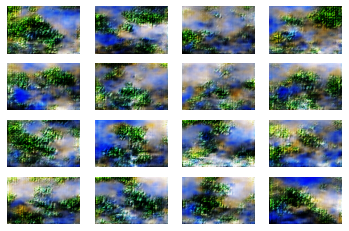

In [0]:
from keras.models import load_model
from matplotlib import pyplot as plt
  
#create and save a plot of generated images
def plot_images(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i],aspect='auto')
	plt.show()

model = load_model('/content/drive/My Drive/cgan_generator.h5')
latent_points, labels = gan.generate_latent_points(40)
labels = np.asarray([gan.one_hot_encode(x) for _ in range(10) for x in range(4)])
X  = model.predict([latent_points, labels])
X = (127.5*X +127.5).astype('int')
plot_images(X, 4)

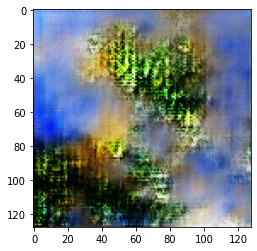

In [0]:
latent_points, labels = gan.generate_latent_points(1)
labels = np.array([gan.one_hot_encode(2)])
X  = model.predict([latent_points, labels])
X = (127.5*X +127.5).astype('int')
plt.imshow(X[0])

[9]


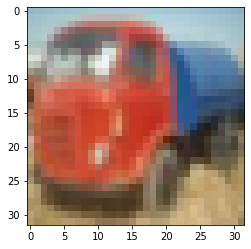

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(y_train[102])
plt.imshow(x_train[102])

In [0]:
frame_length=512
resolution = 32
duration=30
pitch_sensitivity=(300-220) * 512 / frame_length
tempo_sensitivity=0.25 * frame_length / 512
depth=1
#set number of classes  
num_classes=10    
#set jitter
jitter=0.5    
#set truncation
truncation=1
#set batch size  
batch_size=20
#set use_previous_classes
smooth_factor=20
frame_lim=int(np.floor(duration*22050/frame_length/batch_size))

In [0]:
#set iput file path : 
inname="No_Roses.mp3"
#set output name
outname='No_Roses.mp4'
y, sr = librosa.load(inname)

In [0]:
def generate_spec_vector(y,sr,n_fft=2048,hop_length=frame_length,n_mels=128):
  spec = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  specm=np.mean(spec,axis=0)
  gradm=np.gradient(specm)
  #set max to 1
  gradm=gradm/np.max(gradm)
  #set value lower than 0 to 0
  gradm = gradm.clip(min=0)
  #normalize to 0-1 
  specm=(specm-np.min(specm))/np.ptp(specm)
  return gradm, specm
def generate_chroma_vector(y,sr,hop_length=frame_length):
  chroma = librosa.feature.chroma_cqt(y, sr=sr, hop_length=frame_length)
  chromasort=np.argsort(np.mean(chroma,axis=1))[::-1]
  return chroma,chromasort
def plot_spectogram(spec,sr,hop_length=frame_length):
  spec_DB = librosa.power_to_db(spec, ref=np.max)
  librosa.display.specshow(spec_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
  plt.colorbar(format='%+2.0f dB');
def plot_chromogram(chroma):
  librosa.display.specshow(chroma, y_axis='chroma')
  plt.colorbar()

In [0]:
gradm, specm = generate_spec_vector(y,sr)
chroma,chromasort = generate_chroma_vector(y,sr)

In [0]:
noise_vector1 = generate_latent_points(100, 1)[0][0]
class_vector1 = one_hot_encode(np.random.randint(0,10))
class_vectors=[class_vector1]
noise_vectors=[noise_vector1]
cvlast=class_vector1
nvlast=noise_vector1 
update_dir=np.zeros(latent_dim)
for ni,n in enumerate(noise_vector1):
    if n<0:
        update_dir[ni] = 1
    else:
        update_dir[ni] = -1
update_last=np.zeros(latent_dim)

In [0]:
def new_jitters(jitter,latent_dim):
    jitters=np.zeros(latent_dim)
    for j in range(latent_dim):
        if np.random.uniform(0,1)<0.5:
            jitters[j]=1
        else:
            jitters[j]=1-jitter        
    return jitters

In [0]:

#get new update directions
def new_update_dir(nv2,update_dir):
    for ni,n in enumerate(nv2):                  
        if n >= 2*truncation - tempo_sensitivity:
            update_dir[ni] = -1  
                        
        elif n < -2*truncation + tempo_sensitivity:
            update_dir[ni] = 1   
    return update_dir

def smooth(class_vectors,smooth_factor):
    
    if smooth_factor==1:
        return class_vectors
    
    class_vectors_terp=[]
    for c in range(int(np.floor(len(class_vectors)/smooth_factor)-1)):  
        ci=c*smooth_factor          
        cva=np.mean(class_vectors[int(ci):int(ci)+smooth_factor],axis=0)
        cvb=np.mean(class_vectors[int(ci)+smooth_factor:int(ci)+smooth_factor*2],axis=0)
                    
        for j in range(smooth_factor):                                 
            cvc = cva*(1-j/(smooth_factor-1)) + cvb*(j/(smooth_factor-1))                                          
            class_vectors_terp.append(cvc)
            
    return np.array(class_vectors_terp)


#normalize class vector between 0-1
def normalize_cv(cv2):
    min_class_val = min(i for i in cv2 if i != 0)
    for ci,c in enumerate(cv2):
        if c==0:
            cv2[ci]=min_class_val    
    cv2=(cv2-min_class_val)/np.ptp(cv2) 
    return cv2

In [0]:
for i in tqdm(range(len(gradm))):   
    
    #print progress
    pass

    #update jitter vector every 100 frames by setting ~half of noise vector units to lower sensitivity
    if i%200==0:
        jitters=new_jitters(jitter,latent_dim)

    #get last noise vector
    nv1=nvlast

    #set noise vector update based on direction, sensitivity, jitter, and combination of overall power and gradient of power
    update = np.array([tempo_sensitivity for k in range(latent_dim)]) * (gradm[i]+specm[i]) * update_dir * jitters 
    
    #smooth the update with the previous update (to avoid overly sharp frame transitions)
    update=(update+update_last*3)/4
    
    #set last update
    update_last=update
        
    #update noise vector
    nv2=nv1+update

    #append to noise vectors
    noise_vectors.append(nv2)
    
    #set last noise vector
    nvlast=nv2
                   
    #update the direction of noise units
    update_dir=new_update_dir(nv2,update_dir)

    #get last class vector
    cv1=cvlast
    
    #generate new class vector
    cv2=np.zeros(10)
    for j in range(10):
        cv2[j] = (cvlast[j] + ((chroma[chromasort[j]][i])/(pitch_sensitivity)))/(1+(1/((pitch_sensitivity))))

    #if more than 6 classes, normalize new class vector between 0 and 1, else simply set max class val to 1
    if num_classes > 6:
        cv2=normalize_cv(cv2)
    else:
        cv2=cv2/np.max(cv2)
    
    #adjust depth    
    cv2=cv2*depth
    
    #this prevents rare bugs where all classes are the same value
    if np.std(cv2[np.where(cv2!=0)]) < 0.0000001:
        cv2[classes[0]]=cv2[classes[0]]+0.01

    #append new class vector
    class_vectors.append(cv2)
    
    #set last class vector
    cvlast=cv2


In [0]:
print(len(noise_vectors))
print(len(class_vectors))
#noise_vectors=noise_vectors[:5760]
#class_vectors = class_vectors[:5760]


In [0]:
model = load_model('cgan_generator.h5')
frames = []
for i in tqdm(range(frame_lim)):
    noise_vector=noise_vectors[i*batch_size:(i+1)*batch_size]
    class_vector=class_vectors[i*batch_size:(i+1)*batch_size]
    X  = model.predict([noise_vector, class_vector])
    X = (X + 1) / 2.0
    #convert to image array and add to frames
    for out in X:    
        im=np.asarray(array_to_img(out,data_format="channels_last"))
        frames.append(im)
      

In [0]:
#Save video  
aud = mpy.AudioFileClip(inname, fps = 44100) 

aud.duration=duration

clip = mpy.ImageSequenceClip(frames, fps=22050/frame_length)
clip = clip.set_audio(aud)
clip.write_videofile(outname,audio_codec='aac')

In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('No_Roses.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)